# Aiayn - Attention is all you Need
![alt text](images/aiayn/aiayn.png "Architecture of AIAYN")

## Positional Encoding
Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the
tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed. There are many choices of positional encodings,
learned and fixed [8].
In this work, we use sine and cosine functions of different frequencies:
P E(pos,2i) = sin(pos/100002i/dmodel)
P E(pos,2i+1) = cos(pos/100002i/dmodel)

where pos is the position and i is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, P Epos+k can be represented as a linear function of
P Epos.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

C:\Users\lucus\OneDrive\Documentos\Cosas\Universidad\3.2\Deep learning for NLP\AIAYN\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def positional_encoding(length: int, depth: int) -> torch.Tensor:
    depth = depth // 2
    positions = torch.arange(length, dtype=torch.float32).unsqueeze(1)  # (seq, 1)
    depths = torch.arange(depth, dtype=torch.float32).unsqueeze(0) / depth  # (1, depth)

    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = torch.cat((torch.sin(angle_rads), torch.cos(angle_rads)), dim=-1)  # (pos, depth*2)
    return pos_encoding

class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        length = x.size(1)
        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x = x + self.pos_encoding[:length, :].unsqueeze(0).to(x.device)
        return x
    
    def compute_mask(self, *args, **kwargs):
        # Implement this if needed
        # TODO: Implement this
        pass

class CommonAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, **kwargs):
        super(CommonAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, **kwargs)
        self.layernorm = nn.LayerNorm(embed_dim)
        self.add = nn.Identity()

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, **kwargs) -> torch.Tensor:
        attn_output, _ = self.mha(query, key, value, **kwargs)
        output = self.add(query + attn_output)
        output = self.layernorm(output)
        return output
    
class CrossAttention(CommonAttention):
    def __init__(self, embed_dim: int, num_heads: int, **kwargs):
        super(CrossAttention, self).__init__(embed_dim, num_heads, **kwargs)
        self.last_attn_scores = None

    def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, need_weights=True)
        self.last_attn_scores = attn_scores
        x = x + attn_output
        x = self.layernorm(x)
        return x
    
class GlobalSelfAttention(CommonAttention):
    def __init__(self, embed_dim: int, num_heads: int, **kwargs):
        super(GlobalSelfAttention, self).__init__(embed_dim, num_heads, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output, _ = self.mha(query=x, key=x, value=x)
        x = x + attn_output
        x = self.layernorm(x)
        return x
    
class CausalSelfAttention(CommonAttention):
    def __init__(self, embed_dim: int, num_heads: int, **kwargs):
        self.num_heads = num_heads
        super(CausalSelfAttention, self).__init__(embed_dim, num_heads, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.size()
        attn_mask = torch.tril(torch.ones((seq_len, seq_len), device=x.device)).unsqueeze(0).unsqueeze(0)
        attn_mask = attn_mask.expand(batch_size * self.num_heads, seq_len, seq_len)
        attn_mask = attn_mask.masked_fill(attn_mask == 0, float('-inf')).masked_fill(attn_mask == 1, float(0.0))
        attn_output, _ = self.mha(query=x, key=x, value=x, attn_mask=attn_mask)
        x = x + attn_output
        x = self.layernorm(x)
        return x

class FeedForward(nn.Module):
    def __init__(self, d_model: int, dff: int, dropout_rate: float = 0.1):
        super(FeedForward, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
            nn.Dropout(dropout_rate)
        )
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.seq(x)
        x = self.layer_norm(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, *, d_model: int, num_heads: int, dff: int, dropout_rate: float = 0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = GlobalSelfAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(nn.Module):
    def __init__(self, *, num_layers: int, d_model: int, num_heads: int,
                 dff: int, vocab_size: int, dropout_rate: float = 0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, *, d_model: int, num_heads: int, dff: int, dropout_rate: float = 0.1):
        super(DecoderLayer, self).__init__()
        self.causal_self_attention = CausalSelfAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout_rate)
        self.cross_attention = CrossAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate)

    def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        x = self.causal_self_attention(x)
        x = self.cross_attention(x, context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, *, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float = 0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ])
        self.last_attn_scores = None

    def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x
    
class Transformer(nn.Module):
    def __init__(self, *, num_layers: int, d_model: int, num_heads: int, dff: int,
                 input_vocab_size: int, target_vocab_size: int, dropout_rate: float = 0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                               dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                               dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, inputs: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        context, x = inputs
        context = self.encoder(context)
        x = self.decoder(x, context)
        logits = self.final_layer(x)
        return logits

## Data

We will now prepare the data. We have found the [dataset](https://www.kaggle.com/datasets/tejasurya/eng-spanish) in [Kaggle](https://www.kaggle.com/), and it consists of 139,013 instances of translations from English to Spanish. The data preprocessing will include taking out the column "metadata", keeping only "input" and "output", as well as dropping duplicates and NA values.

In [3]:
data = pd.read_csv('spa.csv', delimiter='\t', header=None, names=['input', 'output', 'metadata'])

In [4]:
print(len(data))
data.head()

139013


,input,output,metadata
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [5]:
data = data[['input', 'output']]
data.drop_duplicates(inplace=True)
data.dropna(subset=['input', 'output'], inplace=True)

In [6]:
print(len(data))
data.head()

139013


,input,output
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [7]:
# Calculate the length of each input and output sentence
input_lengths = data['input'].apply(len)
output_lengths = data['output'].apply(len)

# Calculate statistics for input lengths
input_mean_length = input_lengths.mean()
input_min_length = input_lengths.min()
input_max_length = input_lengths.max()

# Calculate statistics for output lengths
output_mean_length = output_lengths.mean()
output_min_length = output_lengths.min()
output_max_length = output_lengths.max()

# Print the statistics
print(f'Input Sequence Lengths: Mean = {input_mean_length:.2f}, Min = {input_min_length}, Max = {input_max_length}')
print(f'Output Sequence Lengths: Mean = {output_mean_length:.2f}, Min = {output_min_length}, Max = {output_max_length}')

Input Sequence Lengths: Mean = 31.20, Min = 3, Max = 300
Output Sequence Lengths: Mean = 32.57, Min = 3, Max = 332


Next, we will use a tokenizer to convert the text data into numerical representations that the model can process. Specifically, we use the BERT tokenizer, which breaks down the text into smaller units called tokens and maps each token to a unique identifier. This step is crucial because machine learning models, including Transformers, operate on numerical data rather than raw text. After tokenization, we apply padding and truncation to ensure that all sequences have the same length. Padding adds extra tokens to shorter sequences, while truncation cuts off longer sequences to a specified maximum length. This uniformity in sequence length is important because it allows for efficient batch processing and ensures that all inputs to the model have a consistent shape.

In [8]:
# Tokenizer (using BERT tokenizer for simplicity)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
data['input_ids'] = data['input'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
data['output_ids'] = data['output'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [9]:
input_lengths = data['input_ids'].apply(len)
output_lengths = data['output_ids'].apply(len)

# Calculate percentiles
input_90th_percentile = input_lengths.quantile(0.90)
output_90th_percentile = output_lengths.quantile(0.90)
input_95th_percentile = input_lengths.quantile(0.95)
output_95th_percentile = output_lengths.quantile(0.95)

print(f'90th Percentile of Input Lengths: {input_90th_percentile}')
print(f'90th Percentile of Output Lengths: {output_90th_percentile}')
print(f'95th Percentile of Input Lengths: {input_95th_percentile}')
print(f'95th Percentile of Output Lengths: {output_95th_percentile}')

# Set max_len based on 95th percentile (or 90th)
max_len = int(max(input_90th_percentile, output_90th_percentile))
print(f'Selected max_len for padding: {max_len}')

90th Percentile of Input Lengths: 14.0
90th Percentile of Output Lengths: 19.0
95th Percentile of Input Lengths: 15.0
95th Percentile of Output Lengths: 22.0
Selected max_len for padding: 19


In [10]:
# Pad and truncate
def pad_and_truncate(sequence, max_len):
    if len(sequence) > max_len:
        return sequence[:max_len]
    return sequence + [0] * (max_len - len(sequence))

data['input_ids'] = data['input_ids'].apply(lambda x: pad_and_truncate(x, max_len))
data['output_ids'] = data['output_ids'].apply(lambda x: pad_and_truncate(x, max_len))

In [11]:
# Calculate statistics for input lengths
input_mean_length = input_lengths.mean()
input_min_length = input_lengths.min()
input_max_length = input_lengths.max()

# Calculate statistics for output lengths
output_mean_length = output_lengths.mean()
output_min_length = output_lengths.min()
output_max_length = output_lengths.max()

# Print the statistics
print(f'Input Sequence Lengths: Mean = {input_mean_length:.2f}, Min = {input_min_length}, Max = {input_max_length}')
print(f'Output Sequence Lengths: Mean = {output_mean_length:.2f}, Min = {output_min_length}, Max = {output_max_length}')

Input Sequence Lengths: Mean = 10.05, Min = 4, Max = 84
Output Sequence Lengths: Mean = 13.61, Min = 4, Max = 116


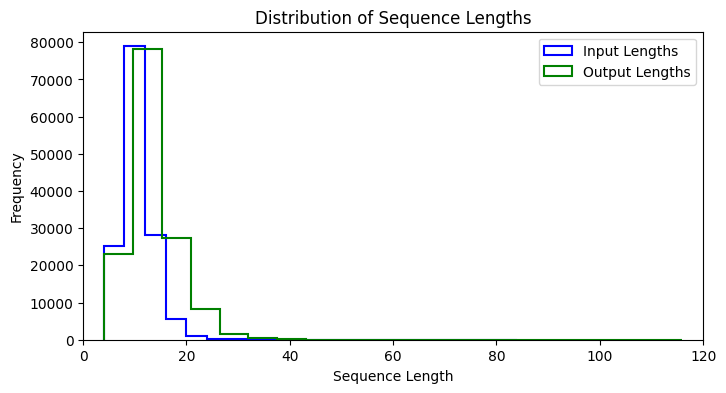

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sequence_lengths(input_lengths, output_lengths):
    plt.figure(figsize=(8, 4))  # Smaller figure size

    # Histogram outlines for input and output lengths
    plt.hist(input_lengths, bins=20, color='blue', edgecolor='blue', histtype='step', linewidth=1.5, label='Input Lengths')
    plt.hist(output_lengths, bins=20, color='green', edgecolor='green', histtype='step', linewidth=1.5, label='Output Lengths')

    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.xlim(0, 120)
    plt.show()

# Plot sequence lengths
plot_sequence_lengths(input_lengths, output_lengths)

In [13]:
def display_examples(data, show_tokens=False):
    print("Some examples of the preprocessed dataset:")

    # Randomize examples
    random_indices = np.random.choice(len(data), size=5, replace=False)
    for i in random_indices:
        print(f"Input: {data['input'].iloc[i]}")
        if show_tokens:
            print(f"Input Tokens: {data['input_ids'].iloc[i]}")
        print(f"Output: {data['output'].iloc[i]}")
        if show_tokens:
            print(f"Output Tokens: {data['output_ids'].iloc[i]}")
        print("\n")

# Show examples with or without tokens
display_examples(data, show_tokens=False)  # Set to True to show tokens

Some examples of the preprocessed dataset:
Input: We need Tom's support.
Output: Necesitamos el apoyo de Tom.


Input: I woke up early yesterday.
Output: Me desperté temprano ayer.


Input: This box won't fit in my suitcase.
Output: Esta caja no entrará en mi maleta.


Input: That's really not the same thing.
Output: Eso no es realmente lo mismo.


Input: My friend ought to have arrived here by now.
Output: Mi amigo ya debería haber llegado.




In [14]:
class TranslationDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.df.iloc[idx]['input_ids'])
        output_ids = torch.tensor(self.df.iloc[idx]['output_ids'])
        return input_ids, output_ids

dataset = TranslationDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)

In [15]:
# Calculate statistics for input lengths
input_mean_length = input_lengths.mean()
input_min_length = input_lengths.min()
input_max_length = input_lengths.max()

# Calculate statistics for output lengths
output_mean_length = output_lengths.mean()
output_min_length = output_lengths.min()
output_max_length = output_lengths.max()

# Print the statistics
print(f'Input Sequence Lengths: Mean = {input_mean_length:.2f}, Min = {input_min_length}, Max = {input_max_length}')
print(f'Output Sequence Lengths: Mean = {output_mean_length:.2f}, Min = {output_min_length}, Max = {output_max_length}')

Input Sequence Lengths: Mean = 10.05, Min = 4, Max = 84
Output Sequence Lengths: Mean = 13.61, Min = 4, Max = 116


In [16]:
import torch.optim as optim

model = Transformer(
    num_layers=2,
    d_model=512,
    num_heads=8,
    dff=2048,
    input_vocab_size=len(tokenizer.vocab),
    target_vocab_size=len(tokenizer.vocab),
    dropout_rate=0.1
)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\lucus\OneDrive\Documentos\Cosas\Universidad\3.2\Deep learning for NLP\AIAYN\myenv\lib\site-packages\ipykernel_launcher.py", line 18, in <modu

In [17]:
def train_step(batch, model, criterion, optimizer):
    model.train()
    inputs, targets = zip(*batch)
    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=tokenizer.pad_token_id)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=tokenizer.pad_token_id)
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    optimizer.zero_grad()
    output = model((inputs, targets[:, :-1]))  # inputs and target sequences shifted for teacher forcing
    loss = criterion(output.view(-1, output.size(-1)), targets[:, 1:].contiguous().view(-1))
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(10):  # 10 epochs for example
    total_loss = 0
    for batch in dataloader:
        loss = train_step(batch, model, criterion, optimizer)
        total_loss += loss
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}') 

RuntimeError: expand(torch.FloatTensor{[1, 1, 18, 18]}, size=[256, 18, 18]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)